# Traveltime tomography using the Eikonal equation (2D case)

@Author: Ettore Biondi - ebiondi@caltech.edu

In [1]:
import occamypy
import numpy as np
import os
import pkg_resources
import scipy.ndimage

# Plotting
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 18, # fontsize for x and y labels (was 10)
    'axes.titlesize': 18,
    'font.size': 18,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'text.usetex':False
}
matplotlib.rcParams.update(params)

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


In [2]:
import operator
def sorting2D(tt, idx_l, ordering="a"):
    idx1 = [idx[0] for idx in idx_l]
    idx2 = [idx[1] for idx in idx_l]
    idx = np.ravel_multi_index(np.array([idx1, idx2]), tt.shape)
    if ordering == "a":
        sorted_indices = np.argsort(tt.ravel()[idx])
    elif ordering == "d":
        sorted_indices = np.argsort(-tt.ravel()[idx])
    else:
        raise ValueError("Unknonw ordering: %s! Provide a or d for ascending or descending" % ordering)
        
    # Sorted indices for entire array
    sorted_indices = idx[sorted_indices]
    
    # Sorting indices
    idx1, idx2 = np.unravel_index(sorted_indices, tt.shape)
    idx_sort = [[ix,iz] for ix, iz in zip(idx1, idx2)]
    return idx_sort

In [3]:
# Fast-Marching-Method (FMM) 
def FMM_tt_2D(tt, vv, dx, dz, status, trial_idx):
    """Function to perform fast-marching method in 2D"""
    nx = vv.shape[0]
    nz = vv.shape[1]
    ns = np.array([nx, nz])
    dx_inv = 1.0 / dx
    dz_inv = 1.0 / dz
    ds_inv = np.array([dx_inv, dz_inv])
    # Various necessary variables
    drxns = [-1, 1]
    nbrs = np.zeros((4,2), dtype=int)
    fdt = np.zeros(2)
    order = np.zeros(2, dtype=int)
    shift = np.zeros(2, dtype=int)
    shift_i = np.zeros(2, dtype=int)
    # FFM main loop
    while len(trial_idx) > 0:
        # Getting trial point with smallest traveltime
        active_idx = trial_idx.pop(0)
        status[active_idx[0], active_idx[1]] = 'k'

        # Creating indices of neighbouring points
        inbr = 0
        for iax in range(2):
            shift.fill(0)
            for idx in range(2):
                shift[iax] = drxns[idx]
                nbrs[inbr][:] = active_idx[:] + shift[:]
                inbr += 1
            
        # Update coefficients
        aa = np.zeros(2) 
        bb = np.zeros(2)
        cc = np.zeros(2)
        # Loop over neighbouring points
        for idx, nb in enumerate(nbrs):
            nb = np.array(nb)
            # If point is outside the domain or has a known traveltime skip it
            if np.any(nb < 0) or np.any(nb >= ns) or status[nb[0], nb[1]] == 'k':
                continue
            # Checking if the velocity model is positive
            if vv[nb[0], nb[1]] > 0:
                fdt.fill(0.0)
                order.fill(0)
                # Computing forward and backward derivatives from nb along each axis
                for iax in range(2):
                    shift.fill(0)
                    for ii in range(2):
                        shift_i.fill(0)
                        shift_i[iax] = drxns[ii]
                        nb_i = nb + shift_i
                        if (np.all(nb_i < ns) and np.all(np.zeros(2) <= nb_i)) and status[nb_i[0], nb_i[1]] == 'k':
                            order[ii] = 1
                            fdt[ii] = drxns[ii] * (tt[nb_i[0], nb_i[1]]-tt[nb[0], nb[1]]) * ds_inv[iax]
                        else:
                            order[ii] = 0
                            fdt[ii] = 0.0
                    # Selecting upwind derivative 
                    if fdt[0] > -fdt[1]:
                        ii, shift[iax] = 0, -1
                    else:
                        ii, shift[iax] = 1, 1
                    # Selecting correct neighbouring point
                    nb_i = nb + shift
                    # Updating traveltime by solving quadratic equation
                    if order[ii] == 0:
                        aa[iax] = bb[iax] = cc[iax] = 0.0
                    else:
                        aa[iax] = ds_inv[iax] * ds_inv[iax]
                        bb[iax] = -2 * aa[iax] * tt[nb_i[0], nb_i[1]]
                        cc[iax] = tt[nb_i[0], nb_i[1]] * tt[nb_i[0], nb_i[1]] * aa[iax]
                # Point out of bounds
                a = np.sum(aa)
                if a == 0:
                    continue
                b = np.sum(bb)
                c = np.sum(cc) - 1/(vv[nb[0], nb[1]]*vv[nb[0], nb[1]])
                det = b*b - 4.0*a*c
                if det < 0.0:
                    # Negative determinant; set it to zero
                    new_t = - b / (2 * a)
                else:
                    new_t = (- b + np.sqrt(det)) / (2*a)
                # Checking if new traveltime is smaller than current estimate for this point
                if new_t < tt[nb[0], nb[1]]:
                    tt[nb[0], nb[1]] = new_t
                    if status[nb[0], nb[1]] == 'u':
                        trial_idx.append(nb)
                        status[nb[0], nb[1]] = 't'
                    else:
                        trial_idx = sorting2D(tt, trial_idx)
    return

In [4]:
class EikonalTT_2D(occamypy.Operator):

    def __init__(self, vel, tt_data, dx, dz, SouPos, RecPos):
        """2D Eikonal-equation traveltime prediction operator"""
        # Setting Domain and Range of the operator
        self.setDomainRange(vel, tt_data)
        # Setting acquisition geometry
        self.nSou = SouPos.shape[0]
        self.nRec = RecPos.shape[0]
        self.SouPos = SouPos.copy()
        self.RecPos = RecPos.copy()
        dataShape = tt_data.shape
        if dataShape[0] != self.nSou:
            raise ValueError("Number of sources inconsistent with traveltime vector (shape[0])")
        if dataShape[1] != self.nRec:
            raise ValueError("Number of receivers inconsistent with traveltime vector (shape[1])")
        self.dx = dx
        self.dz = dz
        self.nx = vel.shape[0]
        self.nz = vel.shape[1]

    def forward(self, add, model, data):
        """Forward non-linear traveltime prediction"""
        self.checkDomainRange(model, data)
        if not add: 
            data.zero()
        dataNd = data.getNdArray()
        velNd = model.getNdArray()
        # Initialization
        tt = np.zeros((self.nx, self.nz))
        for iShot in range(self.nSou):
            # Initial conditions
            status = np.reshape(np.array(["u"]*nx*nz), (nx, nz)) # All points are unknown
            tt.fill(np.inf)
            trial_idx = []
            # Initial conditions
            idx = self.SouPos[iShot,0]
            idz = self.SouPos[iShot,1]
            tt[idx, idz] = 0.0
            status[idx, idz] = 't' # Trial status
            trial_idx.append([idx, idz])
            # Sorting trial time ascending order
            trial_idx = sorting2D(tt, trial_idx)
            FMM_tt_2D(tt, velNd, self.dx, self.dz, status, trial_idx)     
            for iRec in range(self.nRec):
                dataNd[iShot, iRec] += tt[self.RecPos[iRec,0], self.RecPos[iRec,1]]
        return

In [5]:
# Fast-Marching-Method (FMM)
# dx = dz = 0.05
dx = dz = 0.1
nx = 201
nz = 101
x = np.linspace(0,(nx-1)*dx, nx)
z = np.linspace(0,(nz-1)*dz, nz)
# Velocity model
vv = np.zeros((nx,nz))
vv[:,:] = 1.0 + z*0.1
vv = occamypy.VectorNumpy(vv)

In [6]:
# Source/Receiver positions
SouPos = np.array([[0,nz-1], [int(nx/2), nz-1], [nx-1, nz-1]])
RecPos = np.array([[ix,0] for ix in np.arange(0,nx)])
# Data vector
tt_data = occamypy.VectorNumpy(np.zeros((SouPos.shape[0], RecPos.shape[0])))
# Setting Forward non-linear operator
Eik2D_Op = EikonalTT_2D(vv, tt_data, dx, dz, SouPos, RecPos)
Eik2D_Op.forward(False, vv, tt_data)

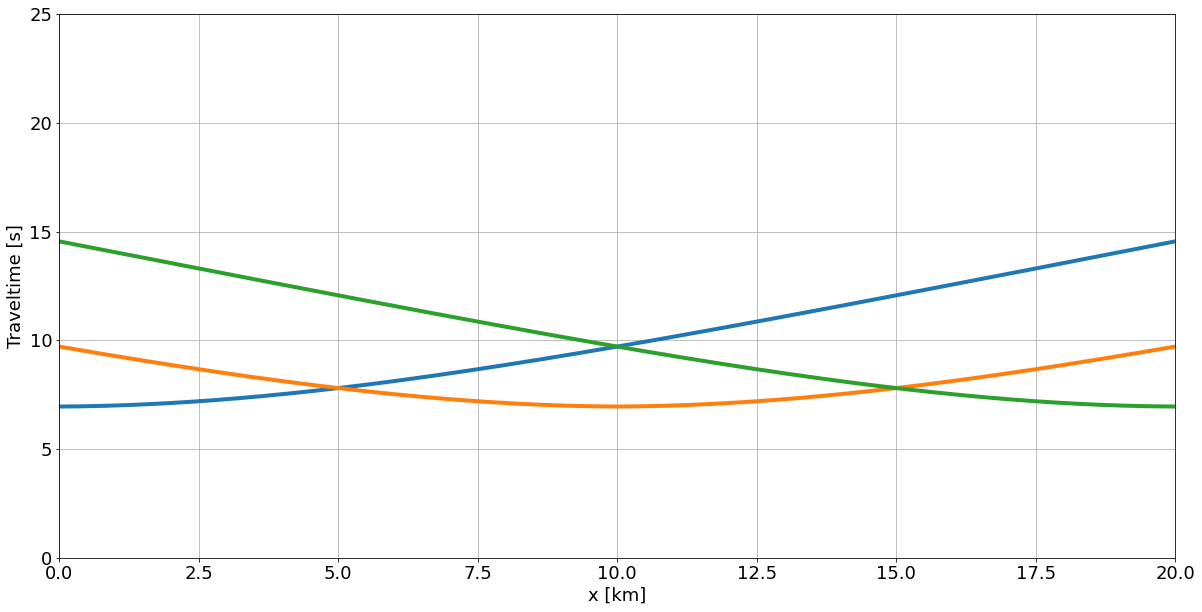

In [7]:
# Plotting traveltime vector
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(RecPos[:,0]*dx, tt_data.getNdArray()[0, :], lw=4)
ax.plot(RecPos[:,0]*dx, tt_data.getNdArray()[1, :], lw=4)
ax.plot(RecPos[:,0]*dx, tt_data.getNdArray()[2, :], lw=4)
ax.grid()
plt.xlabel("x [km]")
plt.ylabel("Traveltime [s]")
plt.ylim([0.0, 25.0])
ax.autoscale(enable=True, axis='x', tight=True)

In [8]:
def FMM_tt_lin_fwd2D(delta_v, delta_tt, vv, tt, dx, dz):
    """Fast-marching method linearized forward"""
    nx = delta_v.shape[0]
    nz = delta_v.shape[1]
    ns = np.array([nx, nz])
    drxns = [-1, 1]
    dx_inv = 1.0 / dx
    dz_inv = 1.0 / dz
    ds_inv = np.array([dx_inv, dz_inv])
    
    # Shift variables
    order = np.zeros(2, dtype=int)
    shift = np.zeros(2, dtype=int)
    idrx = np.zeros(2, dtype=int)
    fdt0 = np.zeros(2)
    
    zz,xx = np.meshgrid(np.arange(nz),np.arange(nx))
    tt_idx = [[xx.flatten()[ii], zz.flatten()[ii]] for ii in range(zz.size)]
    # Sorting traveltime in ascending order
    tt_idx = sorting2D(tt, tt_idx)
    
    # Scaling the velocity perturbation
    delta_v_scaled = - 2.0 * delta_v / (vv * vv * vv)
    
    # Looping over all indices to solve linear equations from increasing traveltime values
    for idx_t0 in tt_idx:
        # If T = 0 or v = 0, then assuming zero to avoid singularity
        if tt[idx_t0[0], idx_t0[1]] == 0.0 or vv[idx_t0[0], idx_t0[1]] == 0.0:
            continue
        
        # Looping over 
        fdt0.fill(0.0)
        idrx.fill(0)
        for iax in range(2):
            # Loop over neighbourning points to find up-wind direction
            fdt = np.zeros(2)
            order.fill(0)
            shift.fill(0)
            for idx in range(2):
                shift[iax] = drxns[idx]
                nb = idx_t0[:] + shift[:]
                # If point is outside the domain skip it
                if np.any(nb < 0) or np.any(nb >= ns):
                    continue
                if vv[nb[0], nb[1]] > 0.0:
                    order[idx] = 1
                    fdt[idx] = drxns[idx] * (tt[nb[0], nb[1]] - tt[idx_t0[0], idx_t0[1]]) * ds_inv[iax]
                else:
                    order[idx] = 0
            # Selecting upwind derivative 
            shift.fill(0)
            if fdt[0] > -fdt[1] and order[0] > 0:
                idrx[iax], shift[iax] = -1, -1
            elif fdt[0] <= -fdt[1] and order[1] > 0:
                idrx[iax], shift[iax] = 1, 1
            else:
                idrx[iax] = 0
            nb = idx_t0[:] + shift[:]
            # Computing t0 space derivative
            fdt0[iax] = idrx[iax] * (tt[nb[0], nb[1]] - tt[idx_t0[0], idx_t0[1]]) * ds_inv[iax] * ds_inv[iax]
        # Using single stencil along z direction to update value
        if tt[idx_t0[0] + idrx[0], idx_t0[1]] > tt[idx_t0[0], idx_t0[1]]:
            denom = - 2.0 * idrx[1] * fdt0[1]
            if abs(denom) > 0.0:
                delta_tt[idx_t0[0], idx_t0[1]] += (- idrx[1] * 2.0 * fdt0[1] * delta_tt[idx_t0[0], idx_t0[1] + idrx[1]] +
                                                   delta_v_scaled[idx_t0[0], idx_t0[1]]) / denom
        # Using single stencil along x direction to update value
        elif tt[idx_t0[0], idx_t0[1] + idrx[1]] > tt[idx_t0[0], idx_t0[1]]:
            denom = - 2.0 * idrx[0] * fdt0[0]
            if abs(denom) > 0.0:
                delta_tt[idx_t0[0], idx_t0[1]] += (- idrx[0] * 2.0 * fdt0[0] * delta_tt[idx_t0[0] + idrx[0], idx_t0[1]] +
                                                   delta_v_scaled[idx_t0[0], idx_t0[1]]) / denom
        else:
            denom = - 2.0 * (idrx[0] * fdt0[0] + idrx[1] * fdt0[1])
            if abs(denom) > 0.0:
                delta_tt[idx_t0[0], idx_t0[1]] += (- idrx[0] * 2.0 * fdt0[0] * delta_tt[idx_t0[0] + idrx[0], idx_t0[1]] +
                                                   - idrx[1] * 2.0 * fdt0[1] * delta_tt[idx_t0[0], idx_t0[1] + idrx[1]] +
                                                   delta_v_scaled[idx_t0[0], idx_t0[1]]) / denom
    return

In [9]:
def select_upwind_der2D(tt, idx_t0, vv, ds_inv, iax):
    """Find upwind derivative along iax"""
    nx = vv.shape[0]
    nz = vv.shape[1]
    ns = np.array([nx, nz])
    nb = np.zeros(2, dtype=int)
    shift = np.zeros(2, dtype=int)
    drxns = [-1, 1]
    fdt = np.zeros(2)
    order = np.zeros(2, dtype=int)
    
    # Computing derivative for the neighboring points along iax
    for idx in range(2):
        shift[iax] = drxns[idx]
        nb[:] = idx_t0[:] + shift[:]
        # If point is outside the domain skip it
        if np.any(nb < 0) or np.any(nb >= ns):
            continue
        if vv[nb[0], nb[1]] > 0.0:
            order[idx] = 1
            fdt[idx] = drxns[idx] * (tt[nb[0], nb[1]]-tt[idx_t0[0], idx_t0[1]]) * ds_inv[iax]
        else:
            order[idx] = 0
    # Selecting upwind derivative 
    if fdt[0] > -fdt[1] and order[0] > 0:
        fd, idrx = fdt[0], -1
    elif fdt[0] <= -fdt[1] and order[1] > 0:
        fd, idrx = fdt[1], 1
    else:
        fd, idrx = 0.0, 0
    return fd, idrx

# Adjoint operator
def FMM_tt_lin_adj2D(delta_v, delta_tt, vv, tt, dx, dz):
    """Fast-marching method linearized forward"""
    nx = delta_v.shape[0]
    nz = delta_v.shape[1]
    ns = np.array([nx, nz])
    drxns = [-1, 1]
    dx_inv = 1.0 / dx
    dz_inv = 1.0 / dz
    ds_inv = np.array([dx_inv, dz_inv])
    
    # Internal variables
    order = np.zeros(2, dtype=int)
    shift = np.zeros(2, dtype=int)
    nbrs = np.zeros((4,2), dtype=int)
    fdt_nb = np.zeros(4)
    order_nb = np.zeros(4, dtype=int)
    idrx_nb = np.zeros(4, dtype=int)
    
    zz,xx = np.meshgrid(np.arange(nz),np.arange(nx))
    tt_idx = [[xx.flatten()[ii], zz.flatten()[ii]] for ii in range(zz.size)]
    # Sorting traveltime in descending order
    tt_idx = sorting2D(tt, tt_idx, ordering="d")
    
    # Looping over all indices to solve linear equations from increasing traveltime values
    for idx_t0 in tt_idx:
        # If T = 0 or v = 0, then assuming zero to avoid singularity
        if tt[idx_t0[0], idx_t0[1]] == 0.0 or vv[idx_t0[0], idx_t0[1]] == 0.0:
            continue
        
        # Creating indices of neighbouring points
        # Order left/right bottom/top
        inbr = 0
        for iax in range(2):
            shift.fill(0)
            for idx in range(2):
                shift[iax] = drxns[idx]
                nbrs[inbr][:] = idx_t0[:] + shift[:]
                inbr += 1
        
        # Looping over neighbouring points
        fdt_nb.fill(0)
        idrx_nb.fill(0)
        for ib, nb in enumerate(nbrs):
            # Point outside of modeling domain
            if np.any(nb < 0) or np.any(nb >= ns):
                order_nb[ib] = 0
                continue
            # Point with lower traveltime compared to current point
            if tt[idx_t0[0], idx_t0[1]] > tt[nb[0], nb[1]]:
                order_nb[ib] = 0
                continue
            order_nb[ib] = 1
            # Getting derivative along given axis
            iax = 0 if ib in [0,1] else 1
            fdt_nb[ib], idrx_nb[ib] = select_upwind_der2D(tt, nb, vv, ds_inv, iax)
            # Removing point if derivative at nb did not use idx_t0
            if ib in [0,1]:
                # Checking x direction
                if idx_t0[0] != nb[0] + idrx_nb[ib]:
                    fdt_nb[ib], idrx_nb[ib] = 0.0, 0
            else:
                # Checking z direction
                if idx_t0[1] != nb[1] + idrx_nb[ib]:
                    fdt_nb[ib], idrx_nb[ib] = 0.0, 0
        
        # Updating delta_v according to stencil
        fdt_nb *= -idrx_nb
        fdt0 = 0.0
        fdt_nb[0] *= dx_inv
        fdt_nb[1] *= dx_inv
        fdt_nb[2] *= dz_inv
        fdt_nb[3] *= dz_inv

        if np.all(order_nb[:2]):
            fdt0, idrx0 = select_upwind_der2D(tt, idx_t0, vv, ds_inv, 1)
            fdt0 *= np.sign(idrx0) * dz_inv
        elif np.all(order_nb[2:]):
            fdt0, idrx0 = select_upwind_der2D(tt, idx_t0, vv, ds_inv, 0)
            fdt0 *= np.sign(idrx0) * dx_inv
        else:
            fdt0x, idrx0x = select_upwind_der2D(tt, idx_t0, vv, ds_inv, 0)
            fdt0z, idrx0z = select_upwind_der2D(tt, idx_t0, vv, ds_inv, 1)
            # Necessary to consider correct stencil central value
            if tt[idx_t0[0], idx_t0[1]] < tt[idx_t0[0] + idrx0x, idx_t0[1]]: 
                fdt0x, idrx0x = 0.0, 0
            if tt[idx_t0[0], idx_t0[1]] < tt[idx_t0[0], idx_t0[1] + idrx0z]: 
                fdt0z, idrx0z = 0.0, 0
            fdt0 = idrx0x * fdt0x * dx_inv + idrx0z * fdt0z * dz_inv
        
        # Update delta_v value
        delta_v[idx_t0[0], idx_t0[1]] -= (  fdt_nb[0] * delta_v[idx_t0[0]-order_nb[0], idx_t0[1]] 
                                          + fdt_nb[1] * delta_v[idx_t0[0]+order_nb[1], idx_t0[1]] 
                                          + fdt_nb[2] * delta_v[idx_t0[0], idx_t0[1]-order_nb[2]] 
                                          + fdt_nb[3] * delta_v[idx_t0[0], idx_t0[1]+order_nb[3]] 
                                          - 0.5 * delta_tt[idx_t0[0], idx_t0[1]]) / fdt0
    
    # Scaling the velocity perturbation
    delta_v[:] = 2.0 * delta_v / (vv * vv * vv)
            
    return

In [10]:
class EikonalTT_lin_2D(occamypy.Operator):

    def __init__(self, vel, tt_data, dx, dz, SouPos, RecPos):
        """2D Eikonal-equation traveltime prediction operator"""
        # Setting Domain and Range of the operator
        self.setDomainRange(vel, tt_data)
        # Setting acquisition geometry
        self.nSou = SouPos.shape[0]
        self.nRec = RecPos.shape[0]
        self.SouPos = SouPos.copy()
        self.RecPos = RecPos.copy()
        dataShape = tt_data.shape
        if dataShape[0] != self.nSou:
            raise ValueError("Number of sources inconsistent with traveltime vector (shape[0])")
        if dataShape[1] != self.nRec:
            raise ValueError("Number of receivers inconsistent with traveltime vector (shape[1])")
        self.dx = dx
        self.dz = dz
        self.nx = vel.shape[0]
        self.nz = vel.shape[1]
        # Background model
        self.vel = vel.clone()
        self.vel.copy(vel)

    def forward(self, add, model, data):
        """Forward linearized traveltime prediction"""
        self.checkDomainRange(model, data)
        if not add: 
            data.zero()
        dataNd = data.getNdArray()
        modelNd = model.getNdArray()
        vel0Nd = self.vel.getNdArray()
        # Initialization
        tt0 = np.zeros((self.nx, self.nz))
        for iShot in range(self.nSou):
            ###################################
            # Computing background traveltime #
            ###################################
            # Initial conditions
            status = np.reshape(np.array(["u"]*nx*nz), (nx, nz)) # All points are unknown
            tt0.fill(np.inf)
            trial_idx = []
            # Initial conditions
            idx = self.SouPos[iShot, 0]
            idz = self.SouPos[iShot, 1]
            tt0[idx, idz] = 0.0
            status[idx, idz] = 't' # Trial status
            trial_idx.append([idx, idz])
            # Sorting trial time ascending order
            trial_idx = sorting2D(tt0, trial_idx)
            FMM_tt_2D(tt0, vel0Nd, self.dx, self.dz, status, trial_idx) 
            ###################################
            # Computing linearized traveltime #
            ###################################
            delta_tt = np.zeros((self.nx, self.nz))
            FMM_tt_lin_fwd2D(modelNd, delta_tt, vel0Nd, tt0, self.dx, self.dz)
            for iRec in range(self.nRec):
                dataNd[iShot, iRec] += delta_tt[self.RecPos[iRec, 0], self.RecPos[iRec, 1]]
        return
    
    def adjoint(self, add, model, data):
        """Adjoint linearized traveltime prediction"""
        self.checkDomainRange(model, data)
        if not add: 
            model.zero()
        dataNd = data.getNdArray()
        modelNd = model.getNdArray()
        vel0Nd = self.vel.getNdArray()
        # Initialization
        tt0 = np.zeros((self.nx, self.nz))
        for iShot in range(self.nSou):
            ###################################
            # Computing background traveltime #
            ###################################
            # Initial conditions
            status = np.reshape(np.array(["u"]*nx*nz), (nx, nz)) # All points are unknown
            tt0.fill(np.inf)
            trial_idx = []
            # Initial conditions
            idx = self.SouPos[iShot, 0]
            idz = self.SouPos[iShot, 1]
            tt0[idx, idz] = 0.0
            status[idx, idz] = 't' # Trial status
            trial_idx.append([idx, idz])
            # Sorting trial time ascending order
            trial_idx = sorting2D(tt0, trial_idx)
            FMM_tt_2D(tt0, vel0Nd, self.dx, self.dz, status, trial_idx) 
            ###################################
            # Computing velocity perturbation #
            ###################################
            delta_tt = np.zeros((self.nx, self.nz))
            delta_v = np.zeros((self.nx, self.nz))
            # Injecting traveltime to correct grid positions
            for iRec in range(self.nRec):
                delta_tt[self.RecPos[iRec, 0], self.RecPos[iRec, 1]] = dataNd[iShot, iRec]
            FMM_tt_lin_adj2D(delta_v, delta_tt, vel0Nd, tt0, self.dx, self.dz)
            modelNd[:] += delta_v
        return
    
    def set_vel(self, vel):
        """Function to set background velocity model"""
        self.vel.copy(vel)

In [11]:
# Dot-product test for the linearized Eikonal equation in 1D
Eik2D_Lin_Op = EikonalTT_lin_2D(vv, tt_data, dx, dz, SouPos, RecPos)
Eik2D_Lin_Op.dotTest(True)

Dot-product tests of forward and adjoint operators
--------------------------------------------------
Applying forward operator add=False
 Runs in: 32.66536283493042 seconds
Applying adjoint operator add=False
 Runs in: 44.73224878311157 seconds
Dot products add=False: domain=3.242823e-01 range=3.242823e-01 
Absolute error: 8.326673e-16
Relative error: 2.567724e-15 

Applying forward operator add=True
 Runs in: 30.72280788421631 seconds
Applying adjoint operator add=True
 Runs in: 41.778603076934814 seconds
Dot products add=True: domain=6.485646e-01 range=6.485646e-01 
Absolute error: 2.109424e-15
Relative error: 3.252450e-15 

-------------------------------------------------


### Inversion

In [48]:
# Fast-Marching-Method (FMM)
# dx = dz = 0.05
dx = dz = 0.1
nx = 201
nz = 101
x = np.linspace(0,(nx-1)*dx, nx)
z = np.linspace(0,(nz-1)*dz, nz)
# Background Velocity model
vv0 = np.zeros((nx,nz))
vv0[:,:] = 1.0 + z*0.1
vv0 = occamypy.VectorNumpy(vv0)
# Gaussian anomaly
zz, xx = np.meshgrid(z, x)
dst = np.sqrt(xx*xx+zz*zz)
sigma = 1.0
xloc = 101*dx
zloc = 51*dz
gauss = np.exp(-( ((xx-xloc)**2 + (zz-zloc)**2) / (2.0*sigma**2)))
# Constructing true model
vv = vv0.clone()
vv.getNdArray()[:] -= gauss*0.5

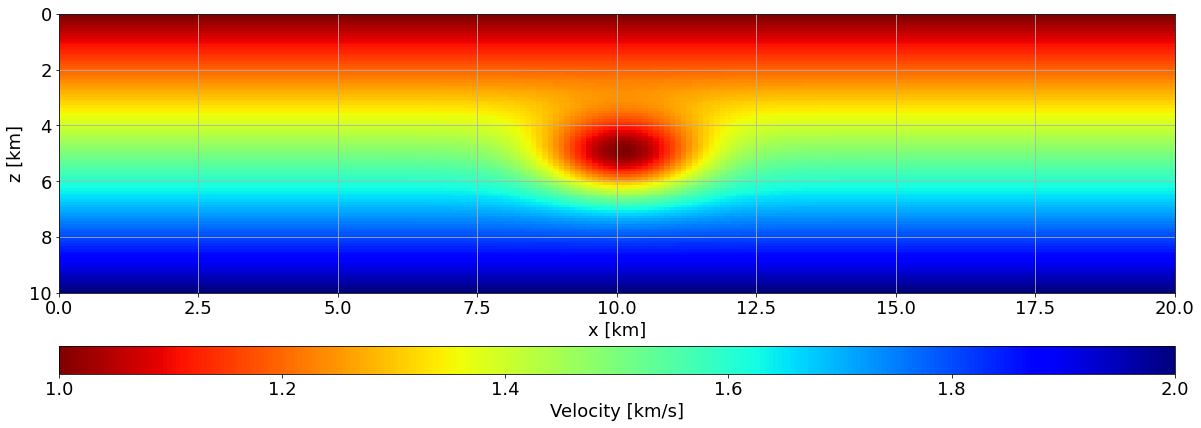

In [144]:
fig, ax = plt.subplots(figsize=(20,10))
im = ax.imshow(vv.getNdArray().T, extent=[x[0], x[-1], z[-1], z[0]],
                cmap=plt.get_cmap("jet_r"), aspect=0.5)
ax = plt.gca()
ax.grid()
plt.xlabel("x [km]")
plt.ylabel("z [km]")
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=-1.2)
cbar = plt.colorbar(im, orientation="horizontal", cax=cax)
cbar.set_label('Velocity [km/s]')

In [94]:
# Source/Receiver positions
SouPos = np.array([[ix,nz-1] for ix in np.arange(0,nx,40)])
RecPos = np.array([[ix,0] for ix in np.arange(0,nx)])
# Data vector
tt_data = occamypy.VectorNumpy(np.zeros((SouPos.shape[0], RecPos.shape[0])))
# Instantiating non-linear operator
Eik2D_Op = EikonalTT_2D(vv, tt_data, dx, dz, SouPos, RecPos)
Eik2D_Lin_Op = EikonalTT_lin_2D(vv, tt_data, dx, dz, SouPos, RecPos)
Eik2D_NlOp = occamypy.NonlinearOperator(Eik2D_Op, Eik2D_Lin_Op, Eik2D_Lin_Op.set_vel)

In [95]:
# Creating observed data
Eik2D_Op.forward(False, vv, tt_data)
tt_data_obs = tt_data.clone()

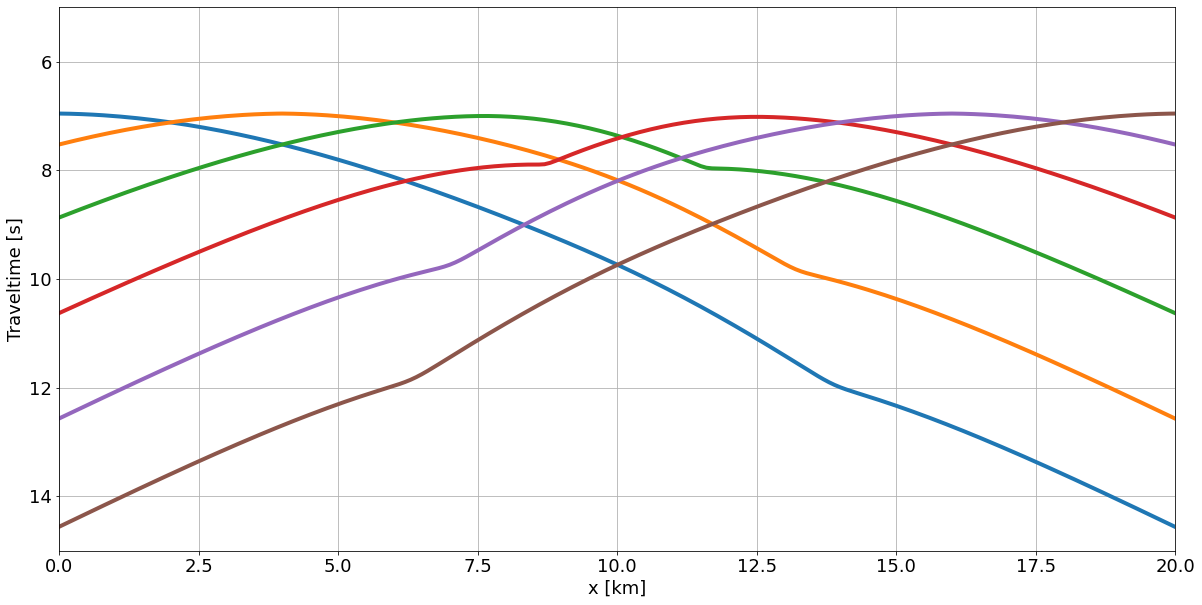

In [130]:
# Plotting traveltime vector
fig, ax = plt.subplots(figsize=(20,10))
for ids in range(SouPos.shape[0]):
    ax.plot(RecPos[:,0]*dx, tt_data.getNdArray()[ids, :], lw=4)
ax.grid()
plt.xlabel("x [km]")
plt.ylabel("Traveltime [s]")
plt.ylim([5.0, 15.0])
ax.autoscale(enable=True, axis='x', tight=True)
ax.invert_yaxis()

In [158]:
v_min = 1.0
v_max = 2.5
minBound = occamypy.VectorNumpy(np.ones((nx,nz))*v_min)
maxBound = occamypy.VectorNumpy(np.ones((nx,nz))*v_max)
niter = 500
Stop  = occamypy.BasicStopper(niter=niter, tolg_proj=1e-32)
BFGSBsolver = occamypy.LBFGSB(Stop, m_steps=30)
# Creating problem object using Smoothing filter and Gradient mask
filt = occamypy.VectorNumpy(np.ones((10,10)))
SmoothOp = occamypy.ConvND(vv0, filt)
Mask = occamypy.VectorNumpy(np.zeros((nx,nz)))
Mask.getNdArray()[int(nx*0.1):int(nx*0.9), int(nz*0.10):int(nz*0.90)] = 1.0
SmoothOp.forward(False, Mask.clone(), Mask)
filt = occamypy.VectorNumpy(np.ones((2,2)))
SmoothOp = occamypy.ConvND(vv0, filt)
Eik2D_Inv_NlOp = occamypy.NonlinearOperator(Eik2D_Op, Eik2D_Lin_Op*SmoothOp, Eik2D_Lin_Op.set_vel)
L2_tt_prob = occamypy.NonlinearLeastSquares(vv0.clone(), tt_data_obs, Eik2D_Inv_NlOp, 
                                            minBound=minBound, maxBound=maxBound, grad_mask=Mask)

In [159]:
BFGSBsolver.run(L2_tt_prob, verbose=True)

##########################################################################################
Limited-memory Broyden-Fletcher-Goldfarb-Shanno with Bounds (L-BFGS-B) algorithm 
Maximum number of steps to be used for Hessian inverse estimation: 30 
Restart folder: /tmp/restart_2021-05-18T22-52-43.907451/
##########################################################################################

iter = 000, obj = 1.43916e+01, resnorm = 5.37e+00, gradnorm = 2.48e+03, feval = 1, geval = 1
iter = 001, obj = 1.30841e+01, resnorm = 5.12e+00, gradnorm = 2.31e+03, feval = 5, geval = 4
iter = 002, obj = 3.93141e+00, resnorm = 2.80e+00, gradnorm = 9.25e+02, feval = 6, geval = 5
iter = 003, obj = 1.52504e+00, resnorm = 1.75e+00, gradnorm = 4.61e+02, feval = 7, geval = 6
iter = 004, obj = 8.50820e-01, resnorm = 1.30e+00, gradnorm = 3.15e+02, feval = 8, geval = 7
iter = 005, obj = 3.27972e-01, resnorm = 8.10e-01, gradnorm = 2.21e+02, feval = 9, geval = 8
iter = 006, obj = 2.09980e-01, resnorm = 6.48e-01

iter = 083, obj = 1.25373e-03, resnorm = 5.01e-02, gradnorm = 2.98e+00, feval = 87, geval = 86
iter = 084, obj = 1.23953e-03, resnorm = 4.98e-02, gradnorm = 9.40e-01, feval = 88, geval = 87
iter = 085, obj = 1.16803e-03, resnorm = 4.83e-02, gradnorm = 3.86e+00, feval = 89, geval = 88
iter = 086, obj = 1.14681e-03, resnorm = 4.79e-02, gradnorm = 1.16e+00, feval = 90, geval = 89
iter = 087, obj = 1.14150e-03, resnorm = 4.78e-02, gradnorm = 1.23e+00, feval = 91, geval = 90
iter = 088, obj = 1.13643e-03, resnorm = 4.77e-02, gradnorm = 1.11e+00, feval = 92, geval = 91
iter = 089, obj = 1.13109e-03, resnorm = 4.76e-02, gradnorm = 1.23e+00, feval = 93, geval = 92
iter = 090, obj = 1.12613e-03, resnorm = 4.75e-02, gradnorm = 1.09e+00, feval = 94, geval = 93
iter = 091, obj = 1.12083e-03, resnorm = 4.73e-02, gradnorm = 1.23e+00, feval = 95, geval = 94
iter = 092, obj = 1.11596e-03, resnorm = 4.72e-02, gradnorm = 1.06e+00, feval = 96, geval = 95
iter = 093, obj = 1.11069e-03, resnorm = 4.71e-02,

iter = 168, obj = 5.43359e-04, resnorm = 3.30e-02, gradnorm = 5.24e-01, feval = 172, geval = 171
iter = 169, obj = 5.41430e-04, resnorm = 3.29e-02, gradnorm = 7.63e-01, feval = 173, geval = 172
iter = 170, obj = 5.39923e-04, resnorm = 3.29e-02, gradnorm = 5.13e-01, feval = 174, geval = 173
iter = 171, obj = 5.37921e-04, resnorm = 3.28e-02, gradnorm = 7.73e-01, feval = 175, geval = 174
iter = 172, obj = 5.36417e-04, resnorm = 3.28e-02, gradnorm = 4.98e-01, feval = 176, geval = 175
iter = 173, obj = 5.34211e-04, resnorm = 3.27e-02, gradnorm = 8.23e-01, feval = 177, geval = 176
iter = 174, obj = 5.32639e-04, resnorm = 3.26e-02, gradnorm = 4.81e-01, feval = 178, geval = 177
iter = 175, obj = 5.30074e-04, resnorm = 3.26e-02, gradnorm = 9.01e-01, feval = 179, geval = 178
iter = 176, obj = 5.28362e-04, resnorm = 3.25e-02, gradnorm = 4.63e-01, feval = 180, geval = 179
iter = 177, obj = 5.25011e-04, resnorm = 3.24e-02, gradnorm = 1.04e+00, feval = 181, geval = 180
iter = 178, obj = 5.22967e-04,

iter = 253, obj = 2.82534e-04, resnorm = 2.38e-02, gradnorm = 3.94e-01, feval = 257, geval = 256
iter = 254, obj = 2.81950e-04, resnorm = 2.37e-02, gradnorm = 3.68e-01, feval = 258, geval = 257
iter = 255, obj = 2.81344e-04, resnorm = 2.37e-02, gradnorm = 3.95e-01, feval = 259, geval = 258
iter = 256, obj = 2.80765e-04, resnorm = 2.37e-02, gradnorm = 3.66e-01, feval = 260, geval = 259
iter = 257, obj = 2.80160e-04, resnorm = 2.37e-02, gradnorm = 3.95e-01, feval = 261, geval = 260
iter = 258, obj = 2.79586e-04, resnorm = 2.36e-02, gradnorm = 3.63e-01, feval = 262, geval = 261
iter = 259, obj = 2.78981e-04, resnorm = 2.36e-02, gradnorm = 3.96e-01, feval = 263, geval = 262
iter = 260, obj = 2.78412e-04, resnorm = 2.36e-02, gradnorm = 3.61e-01, feval = 264, geval = 263
iter = 261, obj = 2.77808e-04, resnorm = 2.36e-02, gradnorm = 3.97e-01, feval = 265, geval = 264
iter = 262, obj = 2.77242e-04, resnorm = 2.35e-02, gradnorm = 3.58e-01, feval = 266, geval = 265
iter = 263, obj = 2.76639e-04,

iter = 338, obj = 2.09263e-04, resnorm = 2.05e-02, gradnorm = 3.35e-01, feval = 342, geval = 341
iter = 339, obj = 2.08904e-04, resnorm = 2.04e-02, gradnorm = 2.81e-01, feval = 343, geval = 342
iter = 340, obj = 2.08502e-04, resnorm = 2.04e-02, gradnorm = 3.37e-01, feval = 344, geval = 343
iter = 341, obj = 2.08145e-04, resnorm = 2.04e-02, gradnorm = 2.79e-01, feval = 345, geval = 344
iter = 342, obj = 2.07742e-04, resnorm = 2.04e-02, gradnorm = 3.40e-01, feval = 346, geval = 345
iter = 343, obj = 2.07386e-04, resnorm = 2.04e-02, gradnorm = 2.76e-01, feval = 347, geval = 346
iter = 344, obj = 2.06980e-04, resnorm = 2.03e-02, gradnorm = 3.43e-01, feval = 348, geval = 347
iter = 345, obj = 2.06626e-04, resnorm = 2.03e-02, gradnorm = 2.73e-01, feval = 349, geval = 348
iter = 346, obj = 2.06217e-04, resnorm = 2.03e-02, gradnorm = 3.46e-01, feval = 350, geval = 349
iter = 347, obj = 2.05864e-04, resnorm = 2.03e-02, gradnorm = 2.70e-01, feval = 351, geval = 350
iter = 348, obj = 2.05450e-04,

iter = 423, obj = 1.45322e-04, resnorm = 1.70e-02, gradnorm = 1.63e-01, feval = 427, geval = 426
iter = 424, obj = 1.44386e-04, resnorm = 1.70e-02, gradnorm = 5.52e-01, feval = 428, geval = 427
iter = 425, obj = 1.43907e-04, resnorm = 1.70e-02, gradnorm = 1.59e-01, feval = 429, geval = 428
iter = 426, obj = 1.42063e-04, resnorm = 1.69e-02, gradnorm = 7.30e-01, feval = 430, geval = 429
iter = 427, obj = 1.41282e-04, resnorm = 1.68e-02, gradnorm = 1.86e-01, feval = 431, geval = 430
iter = 428, obj = 1.41062e-04, resnorm = 1.68e-02, gradnorm = 2.59e-01, feval = 432, geval = 431
iter = 429, obj = 1.40886e-04, resnorm = 1.68e-02, gradnorm = 1.78e-01, feval = 433, geval = 432
iter = 430, obj = 1.40636e-04, resnorm = 1.68e-02, gradnorm = 2.80e-01, feval = 434, geval = 433
iter = 431, obj = 1.40452e-04, resnorm = 1.68e-02, gradnorm = 1.71e-01, feval = 435, geval = 434
iter = 432, obj = 1.40148e-04, resnorm = 1.67e-02, gradnorm = 3.16e-01, feval = 436, geval = 435
iter = 433, obj = 1.39940e-04,

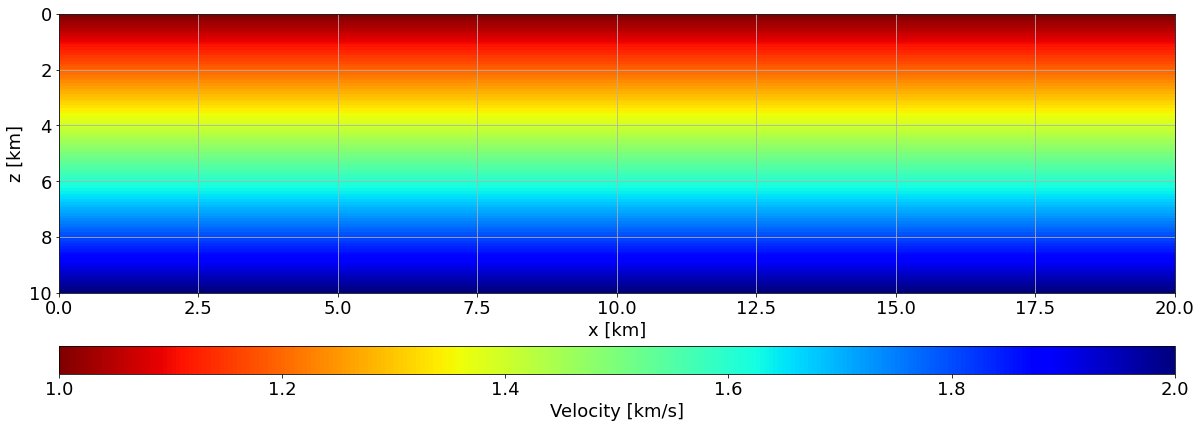

In [160]:
fig, ax = plt.subplots(figsize=(20,10))
im = ax.imshow(vv0.getNdArray().T, extent=[x[0], x[-1], z[-1], z[0]],
                cmap=plt.get_cmap("jet_r"), aspect=0.5)
ax = plt.gca()
ax.grid()
plt.xlabel("x [km]")
plt.ylabel("z [km]")
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=-1.2)
cbar = plt.colorbar(im, orientation="horizontal", cax=cax)
cbar.set_label('Velocity [km/s]')

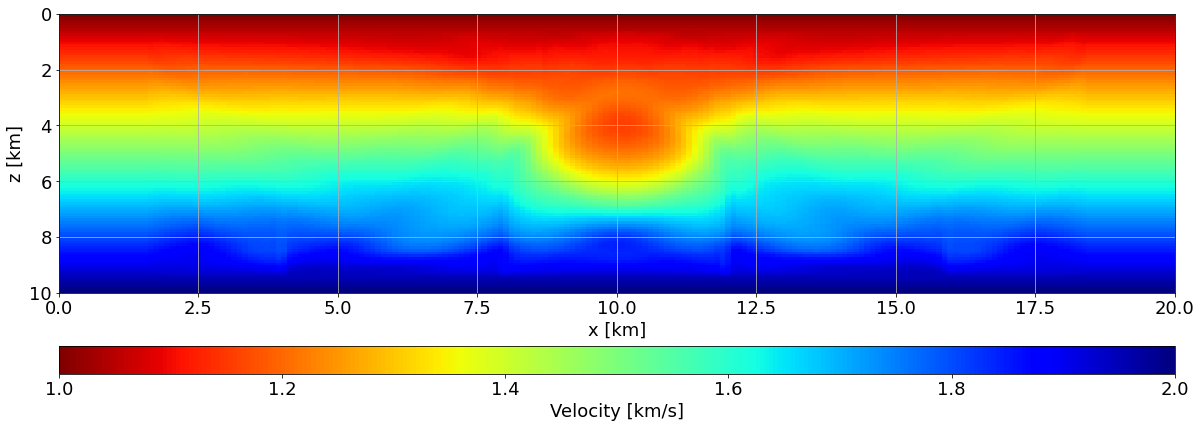

In [161]:
fig, ax = plt.subplots(figsize=(20,10))
im = ax.imshow(L2_tt_prob.model.getNdArray().T, extent=[x[0], x[-1], z[-1], z[0]],
                cmap=plt.get_cmap("jet_r"), aspect=0.5)
ax = plt.gca()
ax.grid()
plt.xlabel("x [km]")
plt.ylabel("z [km]")
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=-1.2)
cbar = plt.colorbar(im, orientation="horizontal", cax=cax)
cbar.set_label('Velocity [km/s]')